In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pickle
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math
import random
import copy
import os
from scipy import stats
import pandas as pd

import statsmodels
import statsmodels.api as sm

from utils import HandlingNets
from models import PositionalEncoding
from models import TransformerModel
from models import LSTMModel
from utils import get_data_tensor
from utils import ma
from utils import get_net_output

In [3]:
torch.cuda.current_device()
print(torch.cuda.get_device_name(0))

GeForce GTX 1080 with Max-Q Design


### General settings

In [4]:
model_type = 'Transformer' # 'LSTM', 'Transformer'

measure_level = 'L2'

measure_mode = 'theta' # 'theta' ONLY!

output_mode = 'r' # 'r', 'dr', 'drrel'

output_tanh = 0 # 0: 'linear', >0: 'tanh', only used wiyth Transformer

continent_knockout = '' # '': all, 'NoEurope', 'NoAsia', 'NoAmerica'

### Reading Data

In [5]:
filename = './Data/data.pkl'
with open(filename, 'rb') as f:
    data = pickle.load(f)

### Nets file name

In [6]:
emsize = 128
precoder_size = 0

n_layers = 2
hidden_size = 100

In [7]:
file_net = model_type + '_' + measure_level + '_' + measure_mode + '_' + output_mode
if model_type == 'Transformer':
    file_net += '_' + str(emsize)
    if precoder_size > 0:
        file_net += '_tanh' + str(precoder_size)
elif model_type == 'LSTM':
    file_net += '_' + str(n_layers) + 'x' + str(hidden_size)
if len(continent_knockout) > 0:
    file_net += '_' + continent_knockout
file_net += '.pt'

In [8]:
file_net

'Transformer_L2_theta_r_128.pt'

### Loading HandlingNets file

In [9]:
#hn = HandlingNets(measure_mode=measure_mode)
hn = HandlingNets()
hn.load_saved_nets(file_net)
config = hn.config
cuda = config['train']['cuda']
countries = hn.countries

ind_min_loss = np.argmin(np.array(hn.nets_min_test_loss))

<BarContainer object of 20 artists>

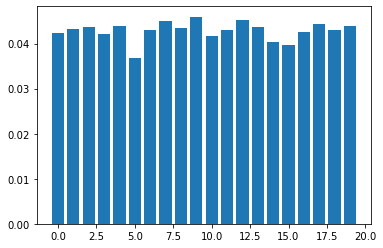

In [10]:
plt.bar(range(len(hn.nets_min_test_loss)), hn.nets_min_test_loss)

In [11]:
def theta_shuffling(country):
    inp0 = data[country]['l2_theta'][:-1]
    inp_delta = np.zeros_like(inp0)
    inp_delta[0] = inp0[0]
    for k, ii in enumerate(inp0[1:]):
        inp_delta[k+1] = ii - inp0[k]
    indsh = np.arange(inp0.shape[0])
    np.random.shuffle(indsh)
    inptemp = inp_delta[indsh]
    inptheta = np.zeros_like(inptemp)
    inptheta[0] = inptemp[0]
    for k in range(1, inptemp.shape[0]):
        inptheta[k] = inptheta[k-1] | inptemp[k]
    inptheta = torch.Tensor(inptheta).unsqueeze(dim=1)
    r = torch.Tensor(data[country]['r'][:-1]).view(-1,1,1)
    #print(inptheta.shape, r.shape)
    inptheta = torch.cat((inptheta, r), 2)
    return inptheta

In [13]:
def evolution_npi_sweep(data, hn, npi, country='Italy', n_days=20, n_best=-1):
        
    measure_mode = hn.measure_mode
    output_mode = hn.output_mode
    cuda = hn.config['train']['cuda']
    inp0, target = get_data_tensor(data, country, measure_mode, output_mode=output_mode, cuda=cuda)
    
    # Checking if the NPI has been taken in this country
    if inp0[:, 0, npi].sum().item() == 0.0:
        print('NPI:', data['L1L2_names'][npi], 'has not been taken in', country)
        return np.array([]), np.array([]), None
    else:
        print('NPI:', data['L1L2_names'][npi])
        starting_day = inp0.shape[0] - inp0[:, 0, npi].sum().item()
    
    nets_min_test_loss = np.array(hn.nets_min_test_loss)
    ind_best = np.argsort(np.array(nets_min_test_loss))
        
    if n_best == -1:
        n_best = len(nets_min_test_loss)
    
    out_nn_ko = np.zeros((len(ind_best), inp0.shape[0]+1))
    out_nn_sweep = np.zeros((inp0.shape[0] - n_days, len(ind_best), inp0.shape[0]+1))
    
    for k_net, ind_net in enumerate(ind_best[:n_best]):
        best_state_dict = hn.nets_best_state_dict[ind_net]
        if model_type == 'Transformer':
            model = TransformerModel(config)
        elif model_type == 'LSTM':
            model = LSTMModel(config)
        if cuda:
            model = model.cuda()
        _ = model.load_state_dict(best_state_dict)
        if cuda:
            model = model.cuda()
        model.eval()

        with torch.no_grad():
            
            # NPI knockout
            inp = inp0.clone()
            inp[:,0,npi] = 0.0
            out_nn_temp = [inp0.cpu().squeeze()[0,-1].item()]
            for k in range(inp.shape[0]):
                inp1 = inp[:k+1].clone()
                inp1[:k+1,0,-1] = torch.FloatTensor(out_nn_temp) #.view(k+1,-1) #[-1]
                out, _ = get_net_output(inp1, model_type, model, cuda)
                out_nn_temp.append(out.flatten().detach().cpu().tolist()[-1])
            out_nn_ko[k_net] = np.array(out_nn_temp)
            
            # Sweeping day evolution
            for day in range(inp0.shape[0] - n_days):
                #out_nn_sweep.append([])
                inp = inp0.clone()
                inp[:,0,npi] = 0.0
                inp[day:,0,npi] = 1.0
                out_nn_temp = [inp0.cpu().squeeze()[0,-1].item()]
                for k in range(inp.shape[0]):
                    inp1 = inp[:k+1].clone()
                    inp1[:k+1,0,-1] = torch.FloatTensor(out_nn_temp) #.view(k+1,-1) #[-1]
                    out, _ = get_net_output(inp1, model_type, model, cuda)
                    out_nn_temp.append(out.flatten().detach().cpu().tolist()[-1])
                out_nn_sweep[day, k_net] = np.array(out_nn_temp)
                
    return np.array(out_nn_ko), np.array(out_nn_sweep), starting_day

In [14]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [15]:
def evolution(data, hn, country='Italy', n_best=-1, mode='normal',
              npis=None, dates=None, r_init=None, ev_time=None):
    measure_mode = hn.measure_mode
    output_mode = hn.output_mode
    cuda = hn.config['train']['cuda']
    inp0, target = get_data_tensor(data, country, measure_mode, output_mode=output_mode, cuda=cuda)
    #print(inp0.shape)
    if mode == 'normal':
        inp = inp0.clone()
        #plt.imshow(inp.cpu().squeeze())
        #plt.show()
    elif mode == 'no_input':
        inp = inp0.clone()
        inp[:,0,:-1] = torch.zeros_like(inp[:,0,:-1])
    elif mode == 'npi_reshuffling':
        if hn.measure_mode == 'delta':
            npish = inp0.cpu().squeeze()[:,:-1][torch.randperm(inp0.shape[0]),:]
            inp = inp0.clone()
            inp[:,0,:-1] = npish
            #plt.imshow(inp.cpu().squeeze()[:,:-1])
            #plt.show()
        elif hn.measure_mode == 'theta':
            inp = theta_shuffling(country)
            if cuda:
                inp = inp.cuda()
    elif mode == 'npi_injecting':
        if ev_time is None:
            inp = inp0.clone()
        else:
            inp = torch.zeros((ev_time,1,inp0.shape[2]))
        inp[:,0,:-1] = torch.zeros_like(inp[:,0,:-1])
        #print(inp.shape)
        for k, npi in enumerate(npis):
            inp[dates[k],0,npi] = 1.
        if hn.measure_mode == 'theta':
            for k in range(1, inp.shape[0]):
                inp[k,0,:-1] = inp[k,0,:-1] + inp[k-1,0,:-1]
            inp[:,0,:-1] = torch.sign(inp[:,0,:-1])

    else:
        raise ValueError('Wrong mode!')
        
    nets_min_test_loss = np.array(hn.nets_min_test_loss)
    ind_best = np.argsort(np.array(nets_min_test_loss))
        
    if n_best == -1:
        n_best = len(nets_min_test_loss)
    
    out_nn = []
    for k_net, ind_net in enumerate(ind_best[:n_best]):
        best_state_dict = hn.nets_best_state_dict[ind_net]
        if model_type == 'Transformer':
            model = TransformerModel(config)
        elif model_type == 'LSTM':
            model = LSTMModel(config)
        if cuda:
            model = model.cuda()
        _ = model.load_state_dict(best_state_dict)
        if cuda:
            model = model.cuda()
        model.eval()

        with torch.no_grad():
            out_nn_temp = [inp0.cpu().squeeze()[0,-1].item()]
            if r_init is not None:
                out_nn_temp = [r_init]
            for k in range(inp.shape[0]):
                inp1 = inp[:k+1].clone()

                inp1[:k+1,0,-1] = torch.FloatTensor(out_nn_temp) #.view(k+1,-1) #[-1]
                #print(inp1.shape)
                out, _ = get_net_output(inp1, model_type, model, cuda)
                #out = model(inp1)
                #print(out.shape)
                out_nn_temp.append(out.flatten().detach().cpu().tolist()[-1])
            out_nn.append(out_nn_temp)
    target = [inp0.cpu().squeeze()[0,-1]] + target.flatten().detach().cpu().tolist()
    
    return np.array(out_nn), np.array(target)

In [17]:
npi2analyze = [9, 27, 10, 14, 43, 16, 39, 23, 6, 8]
for npi in npi2analyze:
    print(npi, data['L1L2_names'][npi])

9 ClosureOfEducationalInstitutions
27 NationalLockdown
10 CordonSanitaire
14 EnhanceLaboratoryTestingCapacity
43 TracingAndTracking
16 IncreaseAvailabilityOfPpe
39 SmallGatheringCancellation
23 MassGatheringCancellation
6 AirportRestriction
8 BorderRestriction


In [18]:
sweep_file = 'NPI_sweeping_Evolution_' + model_type + '.pt'
if os.path.isfile(sweep_file):
    print('Loading file')
    npi_sweep = torch.load(sweep_file)
else:
    print('Starting sweeping')
    npi_sweep = {}

countries2analyze = countries
#countries2analyze = ['Italy', 'Austria', 'France', 'Germany', 'US - New York', 'China',
#                     'Singapore', 'Korea, South', 'Sweden', 'Brazil', 'United Kingdom', 'Japan']

#npi2analyze = list(range(len(data['L1L2_names'])))
npi2analyze = [9, 27, 10, 14, 43, 16, 39, 23, 6, 8]
#npi2analyze = [27]



npi_sweep['l2_names'] = data['L1L2_names']
for country in countries2analyze:
    found = False
    print(country)
    
    for npi in npi2analyze:
        if npi_sweep.get(country) is None:
            out_nn_ko, out_nn_sweep, starting_day = evolution_npi_sweep(data, hn, npi=npi, country=country, 
                                                                     n_days=20, n_best=-1)
            if starting_day is not None:
                npi_sweep[country] = {}
                npi_sweep[country][npi] ={}
                npi_sweep[country][npi]['ko'] = out_nn_ko
                npi_sweep[country][npi]['sweep'] = out_nn_sweep
                npi_sweep[country][npi]['starting_day'] = starting_day
                found = True
        else:
            if npi_sweep[country].get(npi) is None:
                out_nn_ko, out_nn_sweep, starting_day = evolution_npi_sweep(data, hn, npi=npi, country=country, 
                                                                         n_days=20, n_best=-1)
                npi_sweep[country][npi] ={}
                npi_sweep[country][npi]['ko'] = out_nn_ko
                npi_sweep[country][npi]['sweep'] = out_nn_sweep
                npi_sweep[country][npi]['starting_day'] = starting_day
                found = True
                
    if npi_sweep[country].get('evolution') is None:
        normal_evolution, _ = evolution(data, hn, country=country, n_best=-1, mode='normal')
        npi_sweep[country]['evolution'] = normal_evolution
        found = True
        
    if found:
        torch.save(npi_sweep, sweep_file)

Loading file
Albania
Austria
Belgium
Bosnia and Herzegovina
Brazil
Canada
China
Croatia
Czechia
Denmark
Ecuador
El Salvador
Estonia
Finland
France
Germany
Ghana
Greece
Honduras
Hungary
Iceland
India
Indonesia
Ireland
Italy
Japan
Kazakhstan
Korea, South
Kosovo
Kuwait
Lithuania
Malaysia
Mauritius
Mexico
Montenegro
Netherlands
New Zealand
North Macedonia
Norway
Poland
Portugal
Romania
Senegal
Serbia
Singapore
Slovakia
Slovenia
Spain
Sweden
Switzerland
Syria
Taiwan*
Thailand
US - Alabama
US - Alaska
US - Arizona
US - California
US - Colorado
US - Connecticut
US - Delaware
US - Florida
US - Georgia
US - Hawaii
US - Idaho
US - Illinois
US - Indiana
US - Iowa
US - Kansas
US - Kentucky
US - Louisiana
US - Maine
US - Maryland
US - Massachusetts
US - Michigan
US - New York
US - Wisconsin
US - Wyoming
United Kingdom


In [20]:
def plot_sweep(country, npi, npi_sweep, n_days=20):
    if type(country) == str:
        country = [country]
    if type(npi) == int:
        npi = [npi]
    
    for n in npi:
        for c in country:
            
            r = data[c]['r']
            r_mean = []
            for k in range(len(r) - n_days - 1):
                r_mean.append(r[k:k+n_days].mean())
            r_mean = np.array(r_mean)
            
            if npi_sweep.get(c) is not None:
                
                out_nn_norm = npi_sweep[c]['evolution']
                
                if npi_sweep[c].get(n) is not None:
                    out_nn_ko = npi_sweep[c][n]['ko']
                    out_nn_sweep = npi_sweep[c][n]['sweep']
                    starting_day = npi_sweep[c][n]['starting_day']

                    
                    diff_mean_tot = []
                    diff_std_tot = []
                    diff_ci_tot = []
                    sweep_mean_tot = []
                    sweep_std_tot = []
                    sweep_ci_tot = []
                    ko_mean_tot = []
                    ko_std_tot = []
                    ko_ci_tot = []
                    norm_mean_tot = []
                    norm_std_tot = []
                    norm_ci_tot = []
                    for day in range(out_nn_sweep.shape[0]):
                        diff = []
                        sweep = []
                        ko = []
                        norm = []
                        for net in range(out_nn_sweep.shape[1]):
                            diff.append(out_nn_sweep[day, net, day:day+n_days] - out_nn_ko[net, day:day+n_days])
                            sweep.append(out_nn_sweep[day, net, day:day+n_days])
                            ko.append(out_nn_ko[net, day:day+n_days])
                            norm.append(out_nn_norm[net, day:day+n_days])
                        diff = np.array(diff)
                        sweep = np.array(sweep)
                        ko = np.array(ko)
                        norm = np.array(norm)
                        diff_mean = np.mean(diff.flatten())
                        sweep_mean = np.mean(sweep.flatten())
                        ko_mean = np.mean(ko.flatten())
                        norm_mean = np.mean(norm.flatten())
                        diff_std = np.std(diff.flatten())
                        sweep_std = np.std(sweep.flatten())
                        ko_std = np.std(ko.flatten())
                        norm_std = np.std(norm.flatten())
                        _, diff_ci = mean_confidence_interval(diff.flatten())
                        _, sweep_ci = mean_confidence_interval(sweep.flatten())
                        _, ko_ci = mean_confidence_interval(ko.flatten())
                        _, norm_ci = mean_confidence_interval(norm.flatten())
                        diff_mean_tot.append(diff_mean)
                        sweep_mean_tot.append(sweep_mean)
                        ko_mean_tot.append(ko_mean)
                        norm_mean_tot.append(norm_mean)
                        diff_std_tot.append(diff_std)
                        sweep_std_tot.append(sweep_std)
                        ko_std_tot.append(ko_std)
                        norm_std_tot.append(norm_std)
                        diff_ci_tot.append(diff_ci)
                        sweep_ci_tot.append(sweep_ci)
                        ko_ci_tot.append(ko_ci)
                        norm_ci_tot.append(norm_ci)
                    diff_mean_tot = np.array(diff_mean_tot)
                    diff_std_tot = np.array(diff_std_tot)
                    diff_ci_tot = np.array(diff_ci_tot)
                    sweep_mean_tot = np.array(sweep_mean_tot)
                    sweep_std_tot = np.array(sweep_std_tot)
                    sweep_ci_tot = np.array(sweep_ci_tot)
                    ko_mean_tot = np.array(ko_mean_tot)
                    ko_std_tot = np.array(ko_std_tot)
                    ko_ci_tot = np.array(ko_ci_tot)
                    norm_mean_tot = np.array(norm_mean_tot)
                    norm_std_tot = np.array(norm_std_tot)
                    norm_ci_tot = np.array(norm_ci_tot)

                    if starting_day is not None:
                        fig,a =  plt.subplots(1,2,figsize=(15,5))
                        
                        a[0].fill_between(np.arange(diff_mean_tot.shape[0]), diff_mean_tot-diff_std_tot, diff_mean_tot+diff_std_tot, alpha=0.4)
                        a[0].plot(diff_mean_tot)
                        a[0].axhline(0, color='k', alpha=0.5)
                        starting_day = int(starting_day)
                        if starting_day < diff_mean_tot.shape[0]-1:
                            a[0].axvline(starting_day, linestyle='--', color='r', alpha=0.5)
                        a[0].set_title('Difference')
                        
                        a[1].fill_between(np.arange(sweep_mean_tot.shape[0]), sweep_mean_tot-sweep_std_tot,
                                         sweep_mean_tot+sweep_std_tot, alpha=0.4)
                        a[1].plot(sweep_mean_tot, label='NPI sweep')
                        a[1].fill_between(np.arange(ko_mean_tot.shape[0]), ko_mean_tot-ko_std_tot,
                                         ko_mean_tot+ko_std_tot, alpha=0.4)
                        a[1].plot(ko_mean_tot, label='NPI knockout')
                        a[1].plot(range(len(norm_mean_tot)), norm_mean_tot, label='Evolution')
                        
                        if starting_day < diff_mean_tot.shape[0]-1:
                            a[1].axvline(starting_day, linestyle='--', color='r', alpha=0.5)
                            
                        a[1].legend(loc='best')
                        a[1].set_title('Sweeping / Knockout NPI')
                        a[0].set_ylabel('$\Delta R_t$', fontsize=12)
                        a[1].set_ylabel('$R_t$', fontsize=12)
                        a[0].set_xlabel('Sweeping NPI starting day', fontsize=12)
                        a[1].set_xlabel('Sweeping NPI starting day', fontsize=12)
                        fig.subplots_adjust(top=.83)
                        fig.suptitle(data['L1L2_names'][n] + '\n' + c + '\nOriginal starting day: ' + str(int(starting_day)), fontsize=14)
                        plt.show()

In [21]:
def get_diff_gen(npi_sweep, num_days=30):
    diff_gen_dict = {}
    
    for n, l2 in enumerate(data['L1L2_names']):
        diff_gen = []
        
        for c in countries:
            if npi_sweep.get(c) is not None:
                if npi_sweep[c].get(n) is not None:
                    
                    out_nn_ko = npi_sweep[c][n]['ko']
                    out_nn_sweep = npi_sweep[c][n]['sweep']
                    starting_day = npi_sweep[c][n]['starting_day']
                    
                    if starting_day is None:
                        fff = False
                        if data[c]['l2_theta'].shape[0] < (data[c]['l2_theta'][:,n]==0).sum() + 20:
                            fff = True
                        if fff == False:
                            #print(c, starting_day, (data[c]['l2_theta'][:,n]==0).sum(), fff)
                            pass
                    else:
                        #print(c, '- Starting day:', int(starting_day))
                        pass
                    
                    n_days = 20
                    diff_mean_tot = []
                    diff_std_tot = []
                    diff_ci_tot = []
                    sweep_mean_tot = []
                    sweep_std_tot = []
                    sweep_ci_tot = []
                    ko_mean_tot = []
                    ko_std_tot = []
                    ko_ci_tot = []
                    for day in range(out_nn_sweep.shape[0]):
                        diff = []
                        sweep = []
                        ko = []
                        for net in range(out_nn_sweep.shape[1]):
                            diff.append(out_nn_sweep[day, net, day:day+n_days] - out_nn_ko[net, day:day+n_days])
                            sweep.append(out_nn_sweep[day, net, day:day+n_days])
                            ko.append(out_nn_ko[net, day:day+n_days])
                        diff = np.array(diff)
                        sweep = np.array(sweep)
                        ko = np.array(ko)
                        diff_mean = np.mean(diff.flatten())
                        sweep_mean = np.mean(sweep.flatten())
                        ko_mean = np.mean(ko.flatten())
                        diff_std = np.std(diff.flatten())
                        sweep_std = np.std(sweep.flatten())
                        ko_std = np.std(ko.flatten())
                        _, diff_ci = mean_confidence_interval(diff.flatten())
                        _, sweep_ci = mean_confidence_interval(sweep.flatten())
                        _, ko_ci = mean_confidence_interval(ko.flatten())
                        diff_mean_tot.append(diff_mean)
                        sweep_mean_tot.append(sweep_mean)
                        ko_mean_tot.append(ko_mean)
                        diff_std_tot.append(diff_std)
                        sweep_std_tot.append(sweep_std)
                        ko_std_tot.append(ko_std)
                        diff_ci_tot.append(diff_ci)
                        sweep_ci_tot.append(sweep_ci)
                        ko_ci_tot.append(ko_ci)
                    diff_mean_tot = np.array(diff_mean_tot)
                    diff_std_tot = np.array(diff_std_tot)
                    diff_ci_tot = np.array(diff_ci_tot)
                    sweep_mean_tot = np.array(sweep_mean_tot)
                    sweep_std_tot = np.array(sweep_std_tot)
                    sweep_ci_tot = np.array(sweep_ci_tot)
                    ko_mean_tot = np.array(ko_mean_tot)
                    ko_std_tot = np.array(ko_std_tot)
                    ko_ci_tot = np.array(ko_ci_tot)
                    
                    if starting_day is not None:                        
                        diff_gen.append(-diff_mean_tot)
                        starting_day = int(starting_day)

        max_len = 0
        for df in diff_gen:
            if max_len < df.shape[0]:
                max_len = df.shape[0]
        diff_gen0 = np.empty((len(diff_gen), max_len))
        diff_gen0[:] = np.nan

        for k, df in enumerate(diff_gen0):
            df[:len(diff_gen[k])] = diff_gen[k]
        diff_gen_mean = np.nanmean(diff_gen0, axis=0)[:num_days]
        diff_gen_std = np.nanstd(diff_gen0, axis=0)[:num_days]
        
        diff_gen_dict[n] = {}
        diff_gen_dict[n]['single_diffs'] = diff_gen
        diff_gen_dict[n]['diff_gen_mean'] = diff_gen_mean
        diff_gen_dict[n]['diff_gen_std'] = diff_gen_std
        
    return diff_gen_dict

In [22]:
diff_gen_dict = get_diff_gen(npi_sweep, num_days=30)

In [23]:
slope_dict = {}

for n, l2 in enumerate(data['L1L2_names']):
    xx = np.arange(len(diff_gen_dict[n]['diff_gen_mean']))
    ols = sm.OLS(diff_gen_dict[n]['diff_gen_mean'], statsmodels.tools.tools.add_constant(xx.reshape(-1, 1)))
    ols_result = ols.fit()

    slope = ols_result.params[1]
    slope_err = ols_result.bse[1]
    intercept = ols_result.params[0]
    
    slope_dict[n] = {}
    slope_dict[n]['slope'] = slope
    slope_dict[n]['slope_err'] = slope_err
    slope_dict[n]['intercept'] = intercept

In [24]:
l2_correct = []
for npi, l2 in enumerate(data['L1L2_names']):
    ind = []
    for k, c in enumerate(l2):
        if c.isupper():
            ind.append(k)
    ss = ''
    for k, c in enumerate(l2):
        if k in ind and k != 0:
            ss += ' ' + c
        else:
            if c.isdigit() is False:
                ss += c
    l2_correct.append(ss.capitalize())

for npi, l2 in enumerate(l2_correct):
    print(npi, l2)

0 Activate case notification
1 Activate or establish emergency response
2 Actively communicate with healthcare professionals
3 Actively communicate with managers
4 Adapt procedures for patient management
5 Airport health check
6 Airport restriction
7 Border health check
8 Border restriction
9 Closure of educational institutions
10 Cordon sanitaire
11 Crisis management plans
12 Educate and actively communicate with the public
13 Enhance detection system
14 Enhance laboratory testing capacity
15 Environmental cleaning and disinfection
16 Increase availability of ppe
17 Increase healthcare workforce
18 Increase in medical supplies and equipment
19 Increase isolation and quarantine facilities
20 Increase patient capacity
21 Individual movement restrictions
22 Isolation of cases
23 Mass gathering cancellation
24 Measures for public transport
25 Measures for special populations
26 Measures to ensure security of supply
27 National lockdown
28 Personal protective measures
29 Police and army in

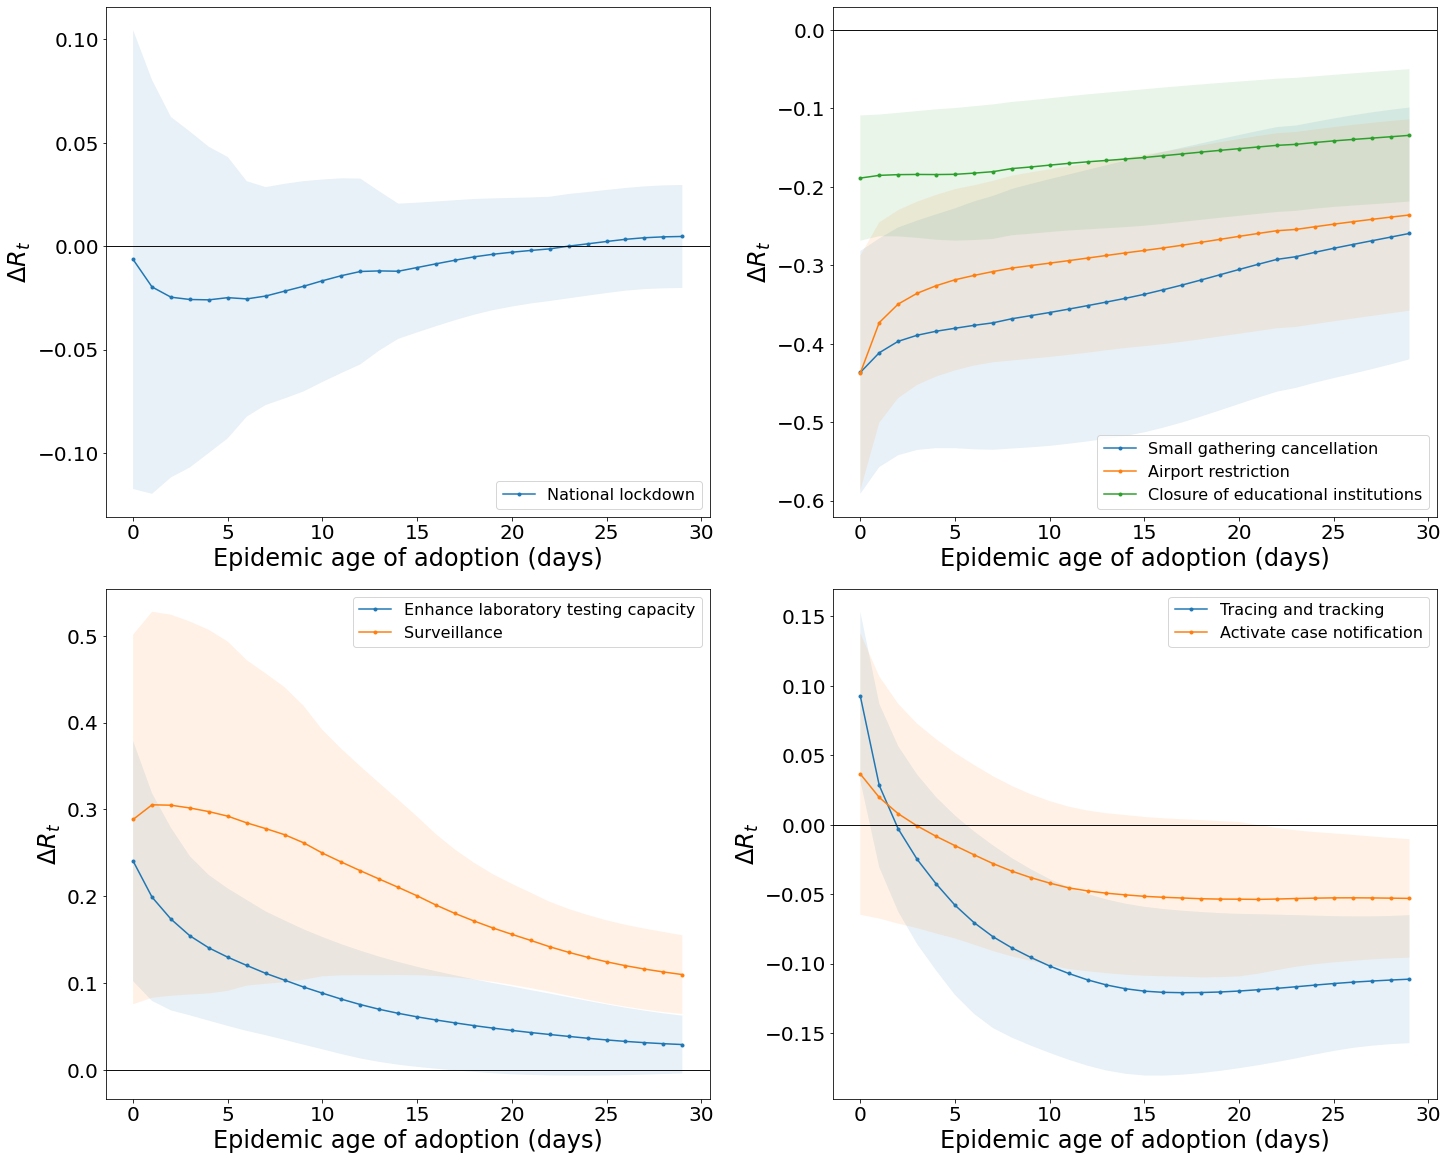

In [25]:
npis = [[27],
        [39, 6, 9], #, 10, 12],
        [14, 41],
        [43, 0]] #, 16]]

fig,a =  plt.subplots(2, 2, figsize=(20,16), constrained_layout=True)
#fig.tight_layout()
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

fontsize = 20
axis_fontsize = 24
label_fontsize = 16

for k, npi in enumerate(npis):
    for n in npi:
        xx = int(k/2)
        yy = k % 2
        a[xx][yy].fill_between(range(len(diff_gen_dict[n]['diff_gen_mean'])), -diff_gen_dict[n]['diff_gen_mean']+diff_gen_dict[n]['diff_gen_std'], 
                      -diff_gen_dict[n]['diff_gen_mean']-diff_gen_dict[n]['diff_gen_std'], alpha=0.1)
        a[xx][yy].plot(-diff_gen_dict[n]['diff_gen_mean'], '.-', label = l2_correct[n])
        a[xx][yy].axhline(lw=1, c='#111111')
    if xx == 0:
        a[xx][yy].legend(loc='lower right', fontsize=label_fontsize)
    else:
        a[xx][yy].legend(loc='upper right', fontsize=label_fontsize)
    for tick in a[xx][yy].xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)
    for tick in a[xx][yy].yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)
    a[xx][yy].set_xlabel('Epidemic age of adoption (days)', fontsize=axis_fontsize)
    a[xx][yy].set_ylabel('$\Delta R_t$', fontsize=axis_fontsize)
    a[xx][yy].set_facecolor('white')
plt.show()

### TETB (The earlier the better)

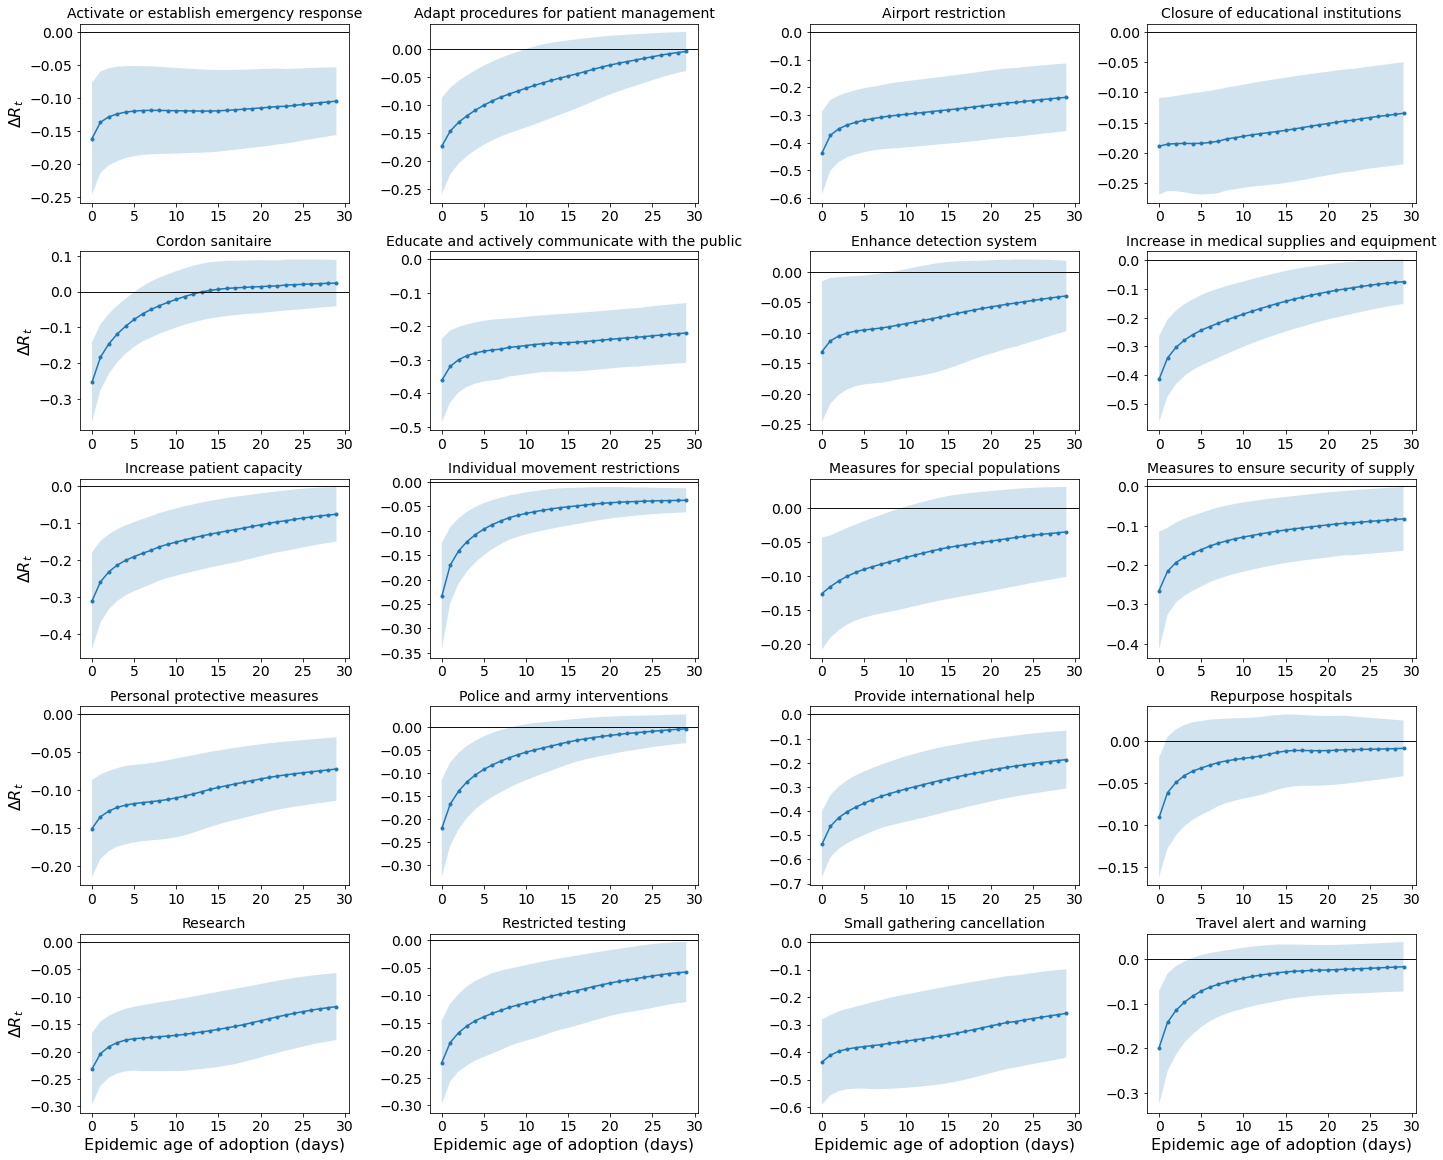

In [30]:
npis = [ 1,  4,  6,  9, 10, 12, 13, 18, 20, 21, 25, 26, 28, 29, 31, 35, 36, 37, 39, 44]

ncols = 4
nrows = int(np.ceil(len(npis) / 4))
#print(ncols, nrows, len(npis), len(npis)/4)

fig,a =  plt.subplots(nrows, ncols, figsize=(20,16), constrained_layout=True)
#fig.tight_layout()
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

ticks_fontsize = 14
axis_fontsize = 16
title_fontsize = 14

for k, n in enumerate(npis):
    xx = int(k / ncols)
    yy = k % ncols
    a[xx][yy].fill_between(range(len(diff_gen_dict[n]['diff_gen_mean'])), -diff_gen_dict[n]['diff_gen_mean']+diff_gen_dict[n]['diff_gen_std'], 
                  -diff_gen_dict[n]['diff_gen_mean']-diff_gen_dict[n]['diff_gen_std'], alpha=0.2)
    a[xx][yy].plot(-diff_gen_dict[n]['diff_gen_mean'], '.-')
    a[xx][yy].axhline(lw=1, c='#111111')
    

    for tick in a[xx][yy].xaxis.get_major_ticks():
        tick.label.set_fontsize(ticks_fontsize)
    for tick in a[xx][yy].yaxis.get_major_ticks():
        tick.label.set_fontsize(ticks_fontsize)
    if xx == nrows - 1:
        a[xx][yy].set_xlabel('Epidemic age of adoption (days)', fontsize=axis_fontsize)
    if yy == 0:
        a[xx][yy].set_ylabel('$\Delta R_t$', fontsize=axis_fontsize)
    a[xx][yy].set_facecolor('white')
    a[xx][yy].set_title(l2_correct[n], fontsize=title_fontsize)
plt.show()

### Peak + Decreasing

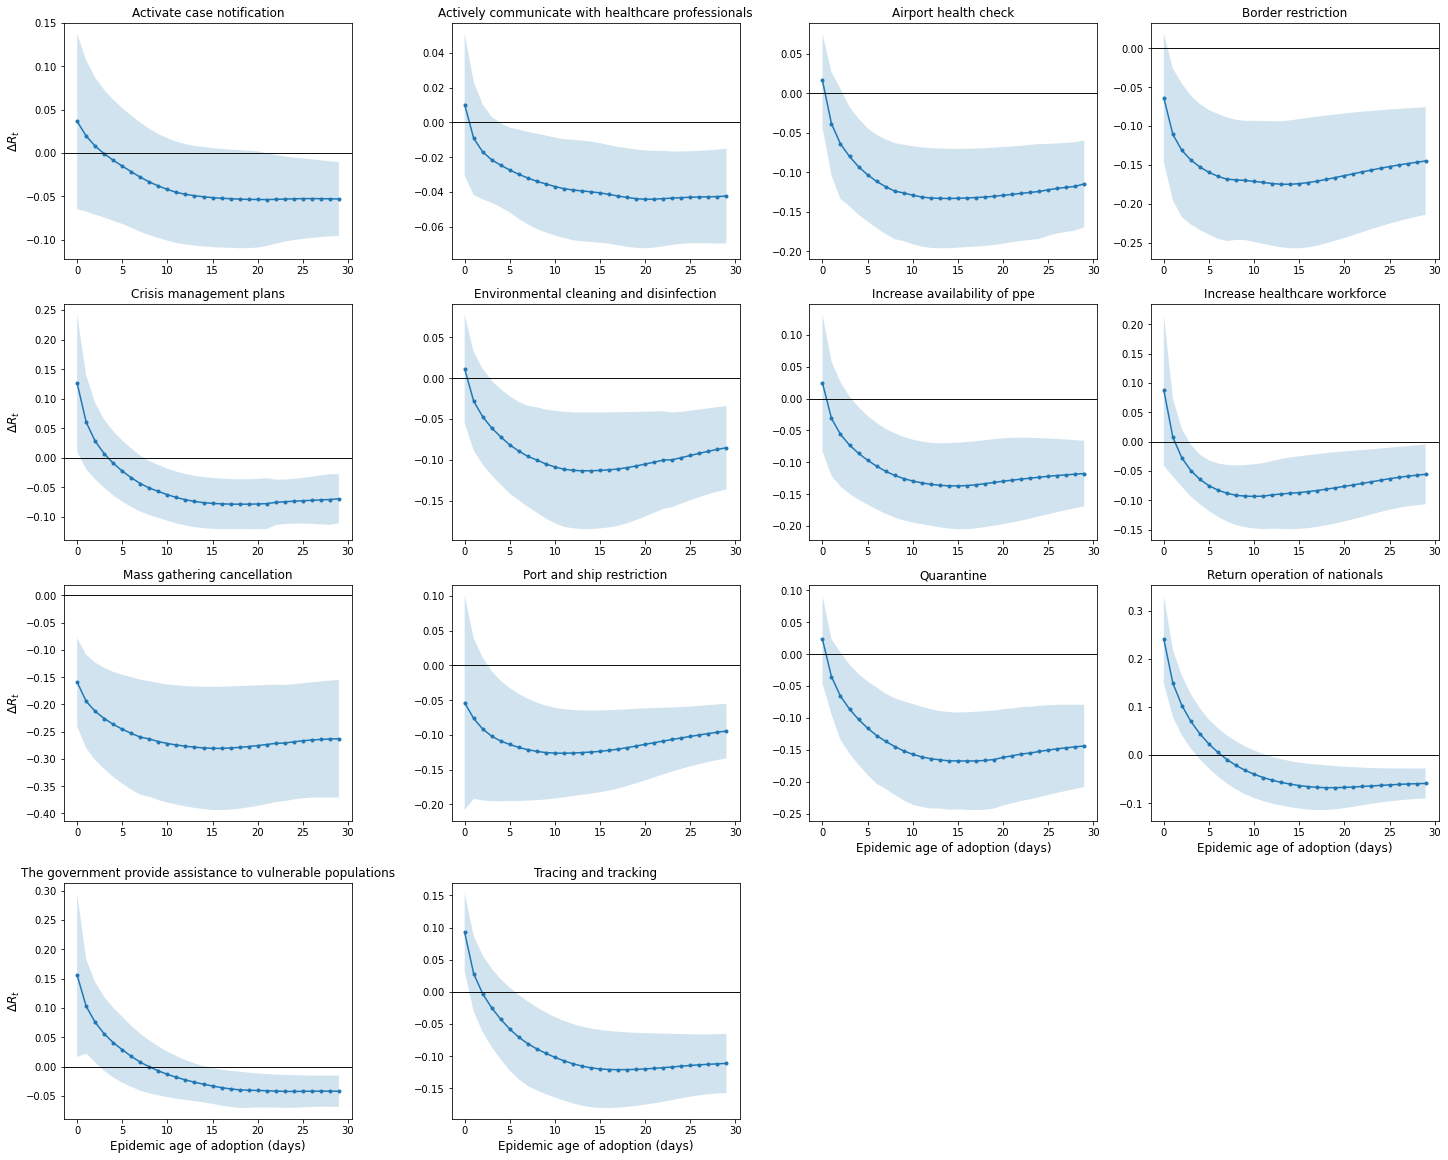

In [31]:
npis = [ 0, 2, 5, 8, 11, 15, 16, 17, 23, 30, 33, 38, 42, 43]

ncols = 4
nrows = int(np.ceil(len(npis) / 4))

fig, a =  plt.subplots(nrows, ncols, figsize=(20,16), constrained_layout=True)

ticks_fontsize = 10
axis_fontsize = 12

for k, n in enumerate(npis):
    xx = int(k / ncols)
    yy = k % ncols
    a[xx][yy].fill_between(range(len(diff_gen_dict[n]['diff_gen_mean'])), -diff_gen_dict[n]['diff_gen_mean']+diff_gen_dict[n]['diff_gen_std'], 
                  -diff_gen_dict[n]['diff_gen_mean']-diff_gen_dict[n]['diff_gen_std'], alpha=0.2)
    a[xx][yy].plot(-diff_gen_dict[n]['diff_gen_mean'], '.-')
    a[xx][yy].axhline(lw=1, c='#111111')
    

    for tick in a[xx][yy].xaxis.get_major_ticks():
        tick.label.set_fontsize(ticks_fontsize)
    for tick in a[xx][yy].yaxis.get_major_ticks():
        tick.label.set_fontsize(ticks_fontsize)
    if xx == nrows - 1:
        a[xx][yy].set_xlabel('Epidemic age of adoption (days)', fontsize=axis_fontsize)
    if yy == 0:
        a[xx][yy].set_ylabel('$\Delta R_t$', fontsize=axis_fontsize)
    a[xx][yy].set_facecolor('white')
    a[xx][yy].set_title(l2_correct[n])

# Axis to delete    
for k in range(len(npis), nrows*ncols):
    xx = int(k / ncols)
    yy = k % ncols
    fig.delaxes(a[xx][yy])
    
# Add xlabels to upper plots

if nrows*ncols != len(npis):
    diff = nrows*ncols - len(npis)
    fr = len(npis) - ncols
    to = fr + diff
    
    for k in range(fr, to):
        yy = k % ncols
        xx = nrows - 2
        a[xx][yy].set_xlabel('Epidemic age of adoption (days)', fontsize=axis_fontsize)
        
plt.show()

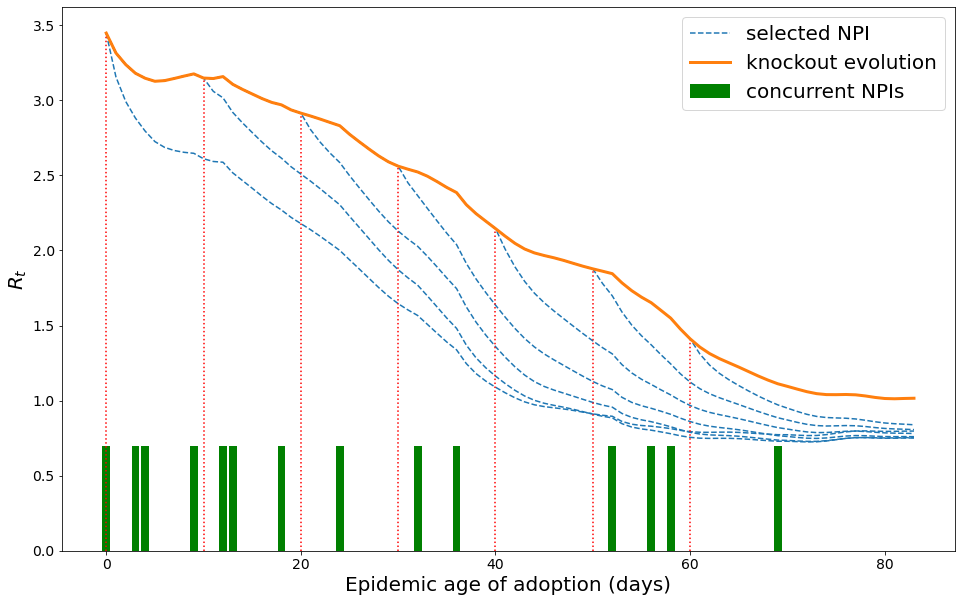

In [34]:
country = 'Italy'

npi = 42
npi = 39
#npi = 27
#npi = 40

day = 20

days = [0, 10, 20, 30, 40, 50, 60]

plt.figure(figsize=(16,10))
#plt.plot(npi_sweep['Italy']['evolution'].mean(axis=0), label='evolution')

npis_starting_day =[]
for n, l2 in enumerate(l2_correct):
    if data[country]['l2_theta'][:,n].sum() > 0:
        npis_starting_day.append((data[country]['l2_theta'][:,n] == 0).sum())

npis_starting_day = sorted(list(set(npis_starting_day)))

ticks_fontsize = 14
axis_fontsize = 20
legend_fontsize = 20

for day in days:
    if day == 0:
        plt.plot(npi_sweep[country][npi]['sweep'][day,:,:].mean(axis=0), '--', color=colors[0], label='selected NPI')
    else:
        plt.plot(npi_sweep[country][npi]['sweep'][day,:,:].mean(axis=0), '--', color=colors[0])
    plt.plot([day,day], [0,npi_sweep[country][npi]['sweep'][day,:,:].mean(axis=0)[day]], ':', color='r')
plt.plot(npi_sweep[country][npi]['ko'].mean(axis=0), color=colors[1], label='knockout evolution', linewidth=3)

plt.bar(npis_starting_day, [0.7]*len(npis_starting_day), color='g', label='concurrent NPIs')#colors[9])
#plt.plot(npis_starting_day, [-3.7]*len(npis_starting_day), 'd', color='g', label='concurrent NPIs', markersize=12)#colors[9])

plt.xlabel('Epidemic age of adoption (days)', fontsize=axis_fontsize)
plt.ylabel('$R_t$', fontsize=axis_fontsize)

plt.xticks(fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)
#plt.hlines(-4, )

#plt.ylim(-3.75, -0.5)
#import matplotlib.ticker as mtick
#plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: x-4))
#plt.xticks(np.arange(0, 90, 10))

plt.legend(loc='best', fontsize=legend_fontsize)